# O Que é MBA (Market Basket Analysis)?

O MBA (Market Basket Analysis), ou Análise de Cesta de Compras, é uma técnica analítica utilizada no campo da mineração de dados que busca identificar padrões de compras ou associações entre itens que são frequentemente adquiridos juntos por clientes. Ela é amplamente utilizada em negócios de varejo, e-commerce e em qualquer área onde seja relevante entender os comportamentos de compra dos consumidores.

Em sua essência, a análise de cestas de compras se concentra em entender a relação entre produtos e como esses produtos são combinados nas transações realizadas pelos clientes. A partir desses dados, empresas podem desenvolver estratégias mais eficazes de vendas, como promoções direcionadas, estratégias de cross-selling (venda cruzada), layout de lojas e ofertas personalizadas.

## Objetivos principais do MBA:

1. Identificação de Padrões de Compra: Encontrar itens que são frequentemente comprados juntos.

2. Melhoria de Estratégias de Marketing: Criar promoções, descontos ou sugestões personalizadas com base no comportamento do cliente.

3. Otimização de Estoque e Layout de Loja: Disposição de produtos de forma estratégica para aumentar as vendas, colocando produtos com alto índice de associação próximos uns dos outros.

4. Recomendações de Produtos: Oferecer recomendações de produtos com base nas compras anteriores de um cliente, como acontece em plataformas de e-commerce.

## Métodos Comuns Utilizados:

1. Algoritmo Apriori: Um dos algoritmos mais comuns para encontrar associações entre itens, que busca conjuntos de itens frequentes em transações e gera regras de associação.
    
2. Algoritmo Eclat: Alternativa ao Apriori, com foco em eficiência na descoberta de itemsets frequentes.

## Base de Dados
Você deve criar sua conta no Kaggle e fazer o [Download](https://www.kaggle.com/c/instacart-market-basket-analysis/data) de todos os arquivos.   
Descompacte os arquivos e coloque na pasta onde estiver o Notebook.  
Este [Artigo](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) explica em detalhes como os dados foram gerados

## Instalando e Carregando os Pacotes

In [ ]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Notebook:', python_version())

Versão da Linguagem Python Usada Neste Notebook: 3.10.12


In [ ]:
# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste notebook.
!pip install -q -U watermark

# https://pypi.org/project/efficient-apriori/
!pip install -q -U efficient_apriori # para implementação do algoritmo apriori

# Instalando o Dask com suporte a DataFrame
# O Dask é uma biblioteca poderosa para processamento paralelo e distribuído
# que permite trabalhar com grandes volumes de dados de maneira eficiente.
# Ao instalar com a opção '[dataframe]', estamos incluindo as dependências necessárias
# para manipular DataFrames, que é uma estrutura de dados similar ao Pandas,
# mas projetada para trabalhar com dados que não cabem na memória RAM de uma só vez.
!pip install -q -U dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.1 MB/s eta 0:00:00


In [ ]:
# Imports
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import combinations
import efficient_apriori
from efficient_apriori import apriori

In [ ]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark --iversions

matplotlib       : 3.10.0
pandas           : 2.2.2
platform         : 1.0.8
numpy            : 1.26.4
efficient_apriori: 2.0.5
dask             : 2024.10.0



## Carregando os Dados

In [ ]:
# Carrega os dados
aisle = pd.read_csv('aisles.csv')
department = pd.read_csv('departments.csv')
order = pd.read_csv('orders.csv')
product = pd.read_csv('products.csv')
order_product_train = pd.read_csv('order_products__train.csv')

# Carrega os dados usando Dask para não consumir toda a memória RAM
order_product_prior = dd.read_csv('order_products__prior.csv')

## Análise Exploratória


In [ ]:
aisle.shape

(134, 2)

In [ ]:
# Identificação do corredor e nome do corredor.
aisle.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
department.shape

(21, 2)

In [ ]:
department.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
product.shape

(49688, 4)

In [ ]:
# ID do produto,nome do produto, o corredor aonde o produto se encontra e o departamento.
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
order.shape

(3421083, 7)

In [ ]:
# ID do pedido, id do usuário que fez o pedido, identificação do tipo do pedido, número do pedido,
# dia da semana em que o pedido foi feito, hora do dia em que o pedido foi feito,
# número de dias desde o período anterior.
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
# Total de itens nas categorias de eval_set
order['eval_set'].value_counts()

,count
eval_set,
prior,3214874
train,131209
test,75000


In [ ]:
# Número de linhas e colunas do DataFrame Dask
num_rows = len(order_product_prior)
num_columns = len(order_product_prior.columns)

print(f"Número de linhas: {num_rows}")
print(f"Número de colunas: {num_columns}")

Número de linhas: 32434489
Número de colunas: 4


In [ ]:
# O prior é uma espécie de subset do conjunto de dados acima.
# ID do pedido, id do produto, a ordem pela qual o produto foi adicionado ao carrinho, é uma recompra?
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
order_product_train.shape

(1384617, 4)

In [ ]:
# É um outro subset do dataset de pedidos.
# É o dataset que vamos usar para treinar o algoritmo.
order_product_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
# Total de registros por dataset
count_array = np.array([['Aisles', len(aisle)],
                        ['Department', len(department)],
                        ['Product', len(product)],
                        ['Order', len(order)],
                        ['Order_Product_Prior', len(order_product_prior)],
                        ['Order_Product_Train', len(order_product_train)]])
count_record = pd.DataFrame(count_array, columns = ['Arquivo', 'Total de Registros'])
count_record

,Arquivo,Total de Registros
0,Aisles,134
1,Department,21
2,Product,49688
3,Order,3421083
4,Order_Product_Prior,32434489
5,Order_Product_Train,1384617


## Limpeza dos Dados

### Verificando Valores Ausentes

In [ ]:
aisle.isna().sum()

,0
aisle_id,0
aisle,0


In [ ]:
department.isna().sum()

,0
department_id,0
department,0


In [ ]:
# Representa o número de dias desde que o usuário fez o pedido anterior.
order.isna().sum()

,0
order_id,0
user_id,0
eval_set,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,206209


In [ ]:
product.isna().sum()

,0
product_id,0
product_name,0
aisle_id,0
department_id,0


In [ ]:
  # Calcula o número de valores ausentes por coluna
  na_counts = order_product_prior.isna().sum()
  na_counts_result = na_counts.compute()

  # Exibir os resultados
  print(na_counts_result)

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64


## Feature Extraction

### Merge da Tabela order_product_prior com order, product, aisle e department

In [ ]:
# Merge com as tabelas adicionais
order_product_prior = order_product_prior.merge(order, on='order_id', how='left')
order_product_prior = order_product_prior.merge(product, on='product_id', how='left')
order_product_prior = order_product_prior.merge(aisle, on='aisle_id', how='left')
order_product_prior = order_product_prior.merge(department, on='department_id', how='left')

# Verificar as colunas após o merge
print("Colunas disponíveis em order_product_prior após merge:", order_product_prior.columns)

Colunas disponíveis em order_product_prior após merge: Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'department_id',
       'aisle', 'department'],
      dtype='object')


In [ ]:
# Verificar o resultado com uma amostra dos dados
order_product_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry
5,2,17794,6,1,202279,prior,3,5,9,8.0,Carrots,83,4,fresh vegetables,produce
6,2,40141,7,1,202279,prior,3,5,9,8.0,Original Unflavored Gelatine Mix,105,13,doughs gelatins bake mixes,pantry
7,2,1819,8,1,202279,prior,3,5,9,8.0,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry
8,2,43668,9,0,202279,prior,3,5,9,8.0,Classic Blend Cole Slaw,123,4,packaged vegetables fruits,produce
9,3,33754,1,1,205970,prior,16,5,17,12.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs


In [ ]:
na_counts = order_product_prior.isna().sum().compute()

print(na_counts)

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64


In [ ]:
# Calcular o total de linhas
total_rows = len(order_product_prior)

# Calcular a soma de valores nulos em cada coluna
na_counts = order_product_prior.isnull().sum().compute()

# Calcular o percentual de valores nulos
na_percentage = (na_counts / total_rows) * 100

# Exibir os resultados
print(na_percentage)

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
department                0.00000
dtype: float64


### Merge da Tabela order_product_train com order, product, aisle e department

In [ ]:
%%time
order_product_train = order_product_train.merge(order, on = 'order_id', how = 'left')
order_product_train = order_product_train.merge(product, on = 'product_id', how = 'left')
order_product_train = order_product_train.merge(aisle, on = 'aisle_id', how = 'left')
order_product_train = order_product_train.merge(department, on = 'department_id', how = 'left')

CPU times: user 2.22 s, sys: 624 ms, total: 2.84 s
Wall time: 2.91 s


In [ ]:
order_product_train.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
5,1,13176,6,0,112108,train,4,4,10,9.0,Bag of Organic Bananas,24,4,fresh fruits,produce
6,1,47209,7,0,112108,train,4,4,10,9.0,Organic Hass Avocado,24,4,fresh fruits,produce
7,1,22035,8,1,112108,train,4,4,10,9.0,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs
8,36,39612,1,0,79431,train,23,6,18,30.0,Grated Pecorino Romano Cheese,2,16,specialty cheeses,dairy eggs
9,36,19660,2,1,79431,train,23,6,18,30.0,Spring Water,115,7,water seltzer sparkling water,beverages


In [ ]:
order_product_train.isna().sum()

,0
order_id,0
product_id,0
add_to_cart_order,0
reordered,0
user_id,0
eval_set,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,0


In [ ]:
# Agrupar os dados por 'order_id' e coletar 'product_id'
order_grouped = order_product_prior.groupby('order_id')['product_id'].apply(list, meta=('x', 'object')).reset_index()
order_grouped.head()

,order_id,x
0,7,"[34050, 46802]"
1,52,"[18963, 24852, 39408, 49683, 4485]"
2,65,"[19155, 1940, 25170]"
3,74,"[46667, 14129, 11136, 27247, 17902, 45681, 771..."
4,80,"[10761, 27845, 42118, 24852, 23734, 2295, 26604]"


In [ ]:
# Forçar a computação para obter o DataFrame resultante
order_grouped_df = order_grouped.compute()

In [ ]:
%%time
# Listas para armazenar dados
prod = []
order_ids = order_grouped_df['order_id']

# Extraindo listas de produtos para cada pedido
for i in range(len(order_grouped_df)):
    prod.append(order_grouped_df.iloc[i][1])

# Criar o DataFrame de transações
transactions = pd.DataFrame({
    'OrderID': order_ids,
    'Products': prod
})

<timed exec>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


CPU times: user 3min 57s, sys: 674 ms, total: 3min 58s
Wall time: 4min 3s


In [ ]:
transactions.head(10)

,OrderID,Products
0,7,"[34050, 46802]"
1,52,"[18963, 24852, 39408, 49683, 4485]"
2,65,"[19155, 1940, 25170]"
3,74,"[46667, 14129, 11136, 27247, 17902, 45681, 771..."
4,80,"[10761, 27845, 42118, 24852, 23734, 2295, 26604]"
5,89,"[17794, 20600, 5876, 37011, 26648]"
6,100,"[19660, 196]"
7,115,"[45504, 35003, 48657, 23955, 22920, 23375, 396..."
8,127,"[16797, 9076, 23549, 37052, 4313, 25197, 7644,..."
9,141,"[21131, 16696, 43616, 42972, 6991, 1694, 36316..."


## Análise Estatística Descritiva

### 1- Qual o Número de Pedidos Mais Frequente Entre os Usuários?

In [ ]:
# Agrupa os dados por usuário e número do pedido, agregando pelo maior valor
ord_max_count = order.groupby("user_id")['order_number'].aggregate(np.max).reset_index()
ord_max_count.head()

<ipython-input-38-a6abf879874f>:2: FutureWarning: The provided callable <function max at 0x7c8919594ca0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ord_max_count = order.groupby("user_id")['order_number'].aggregate(np.max).reset_index()


,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [ ]:
# Faz a contagem por número de pedidos
ord_max_count = ord_max_count.order_number.value_counts()
ord_max_count.head()

,count
order_number,
4,23986
5,19590
6,16165
7,13850
8,11700


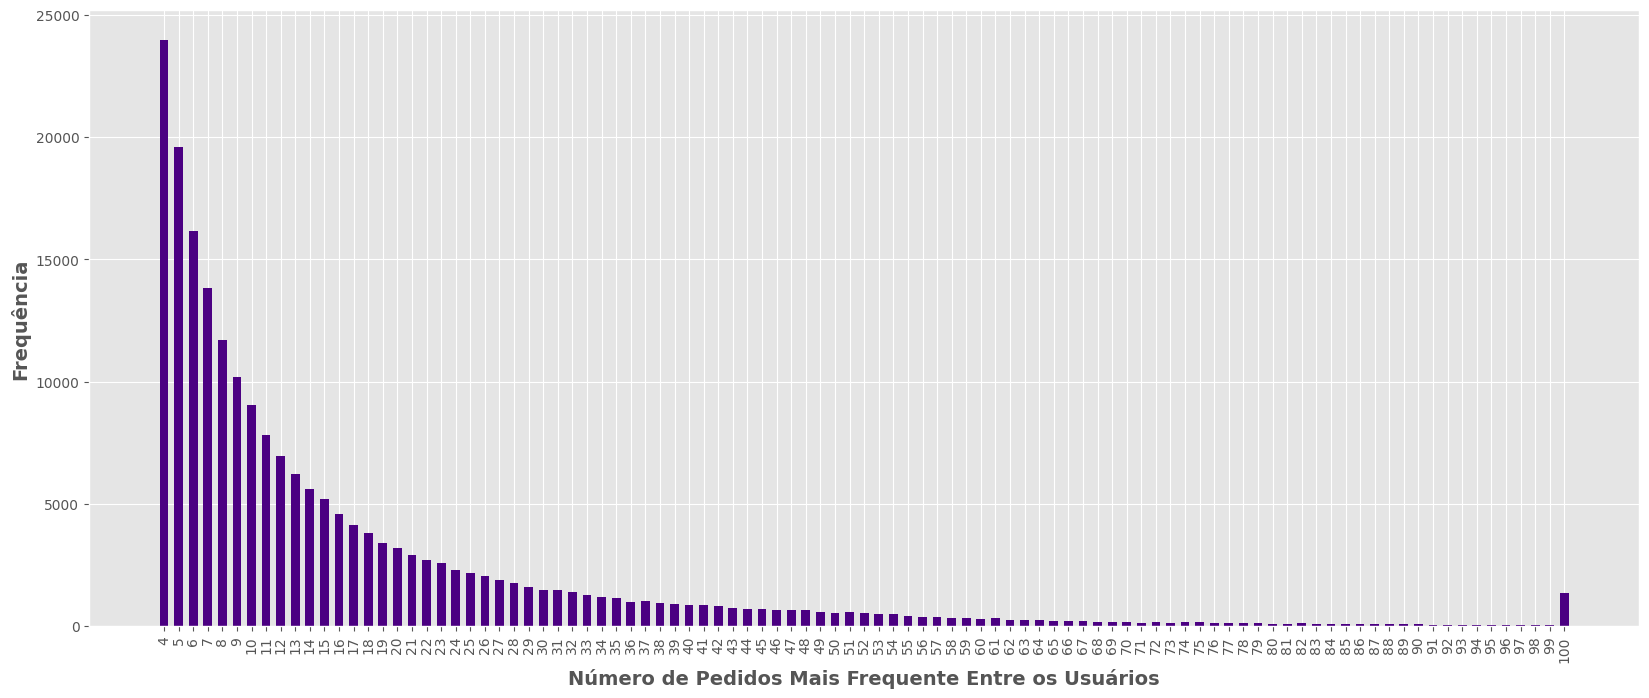

In [ ]:
# Plot
plt.style.use('ggplot')
plt.figure(figsize = (20,8))
plt.bar(ord_max_count.index, ord_max_count.values, color = 'indigo', width = 0.6)
plt.xticks(ord_max_count.index, rotation = 'vertical')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xlabel('Número de Pedidos Mais Frequente Entre os Usuários', fontsize = 14, fontweight = 'bold')
plt.show()

O pedido mais comum é o de número 4.   
A maioria dos usuários fez 4 pedidos.  
A menor frequência está entre 70 e 99.  

### 2- Qual Dia da Semana Tem o Maior Número de Pedidos?

In [ ]:
# Frequências de pedidos por dia da semana (dow = day of the week)
x = [0,1,2,3,4,5,6]
y = [order[order['order_dow']==0].shape[0],
     order[order['order_dow']==1].shape[0],
     order[order['order_dow']==2].shape[0],
     order[order['order_dow']==3].shape[0],
     order[order['order_dow']==4].shape[0],
     order[order['order_dow']==5].shape[0],
     order[order['order_dow']==6].shape[0]]

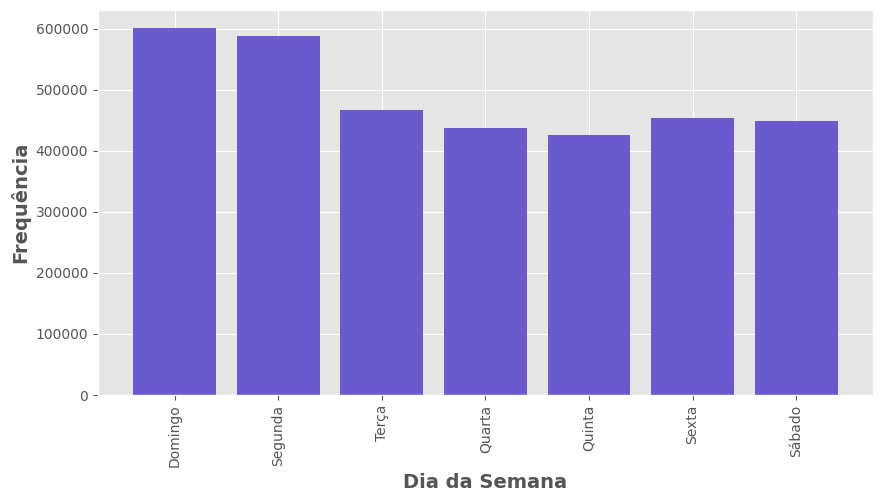

In [ ]:
# Plot
plt.figure(figsize = (10,5))
plt.bar(x,y, color = 'slateblue')
plt.xlabel('Dia da Semana', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xticks(x,['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], rotation = 'vertical')
plt.show()

Para esse dataset, o maior número de pedidos ocorrem no domingo e na segunda-feira.

### 3- Qual Hora do Dia Tem o Maior Número de Pedidos?

In [ ]:
# Frequências de pedidos pela hora do dia
x = list(range(0,24))
y = []
for i in range(24):
    y.append(order[order['order_hour_of_day']==i].shape[0])

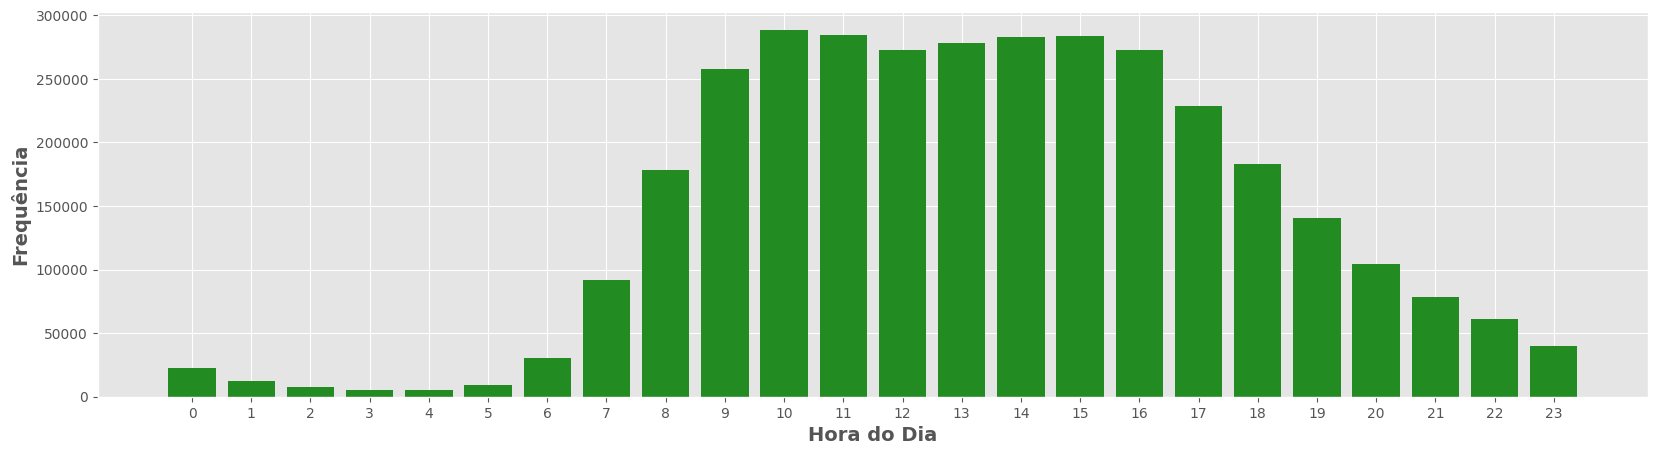

In [ ]:
# Plot
plt.figure(figsize = (20,5))
plt.bar(x,y,color = 'forestgreen')
plt.xticks(np.arange(0,24,1))
plt.xlabel('Hora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

A hora com mais pedidos é 10 horas.

### 4- Qual Departamento Tem o Maior Número de Pedidos?

In [ ]:
# Contagem de pedidos por departamento
dept_cnt = order_product_prior['department'].value_counts()
dept_cnt_pandas = dept_cnt.compute()
dept_cnt_sorted = dept_cnt_pandas.sort_values(ascending=False)

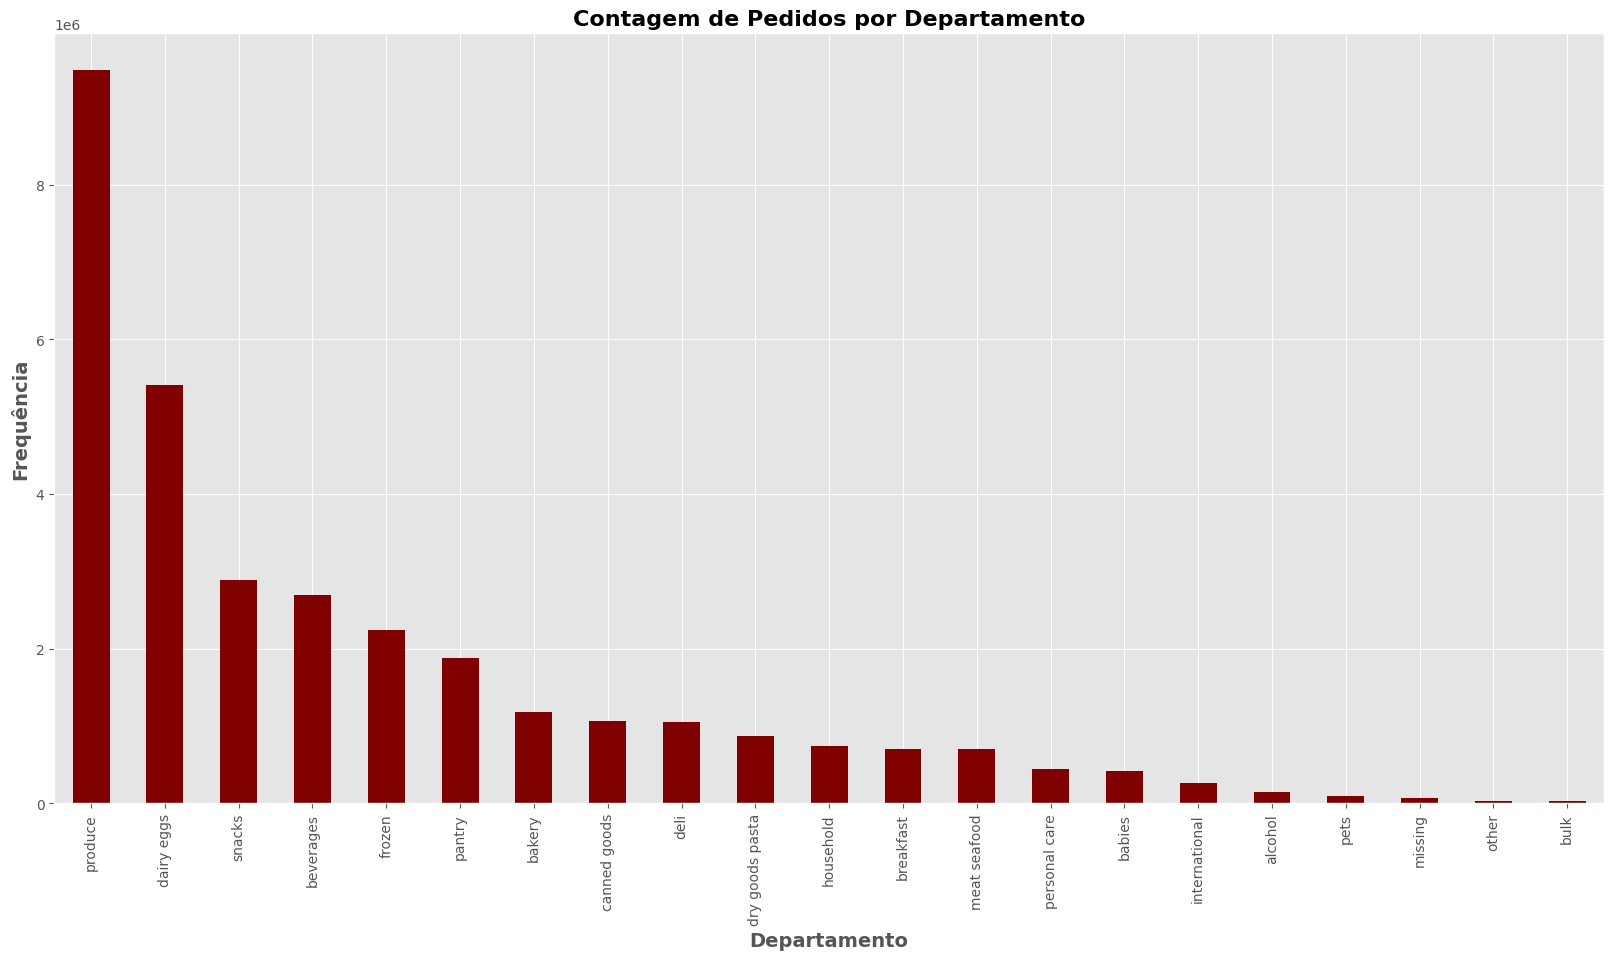

In [ ]:
# Plotar com Pandas
fig = plt.figure(figsize=(20, 10))
dept_cnt_sorted.plot(kind='bar', color='maroon')
plt.xticks(rotation=90)
plt.xlabel('Departamento', fontsize=14, fontweight='bold')
plt.ylabel('Frequência', fontsize=14, fontweight='bold')
plt.title('Contagem de Pedidos por Departamento', fontsize=16, fontweight='bold')
plt.show()

### 5- Quais os 20 Principais Corredores Por Frequência de Pedidos?

In [ ]:
# Obter contagem de pedidos por corredor
aisle_cnt = order_product_prior['aisle'].value_counts()
aisle_cnt = aisle_cnt.compute()

# Selecionar os 20 principais corredores
top_20_aisles = aisle_cnt.nlargest(20)

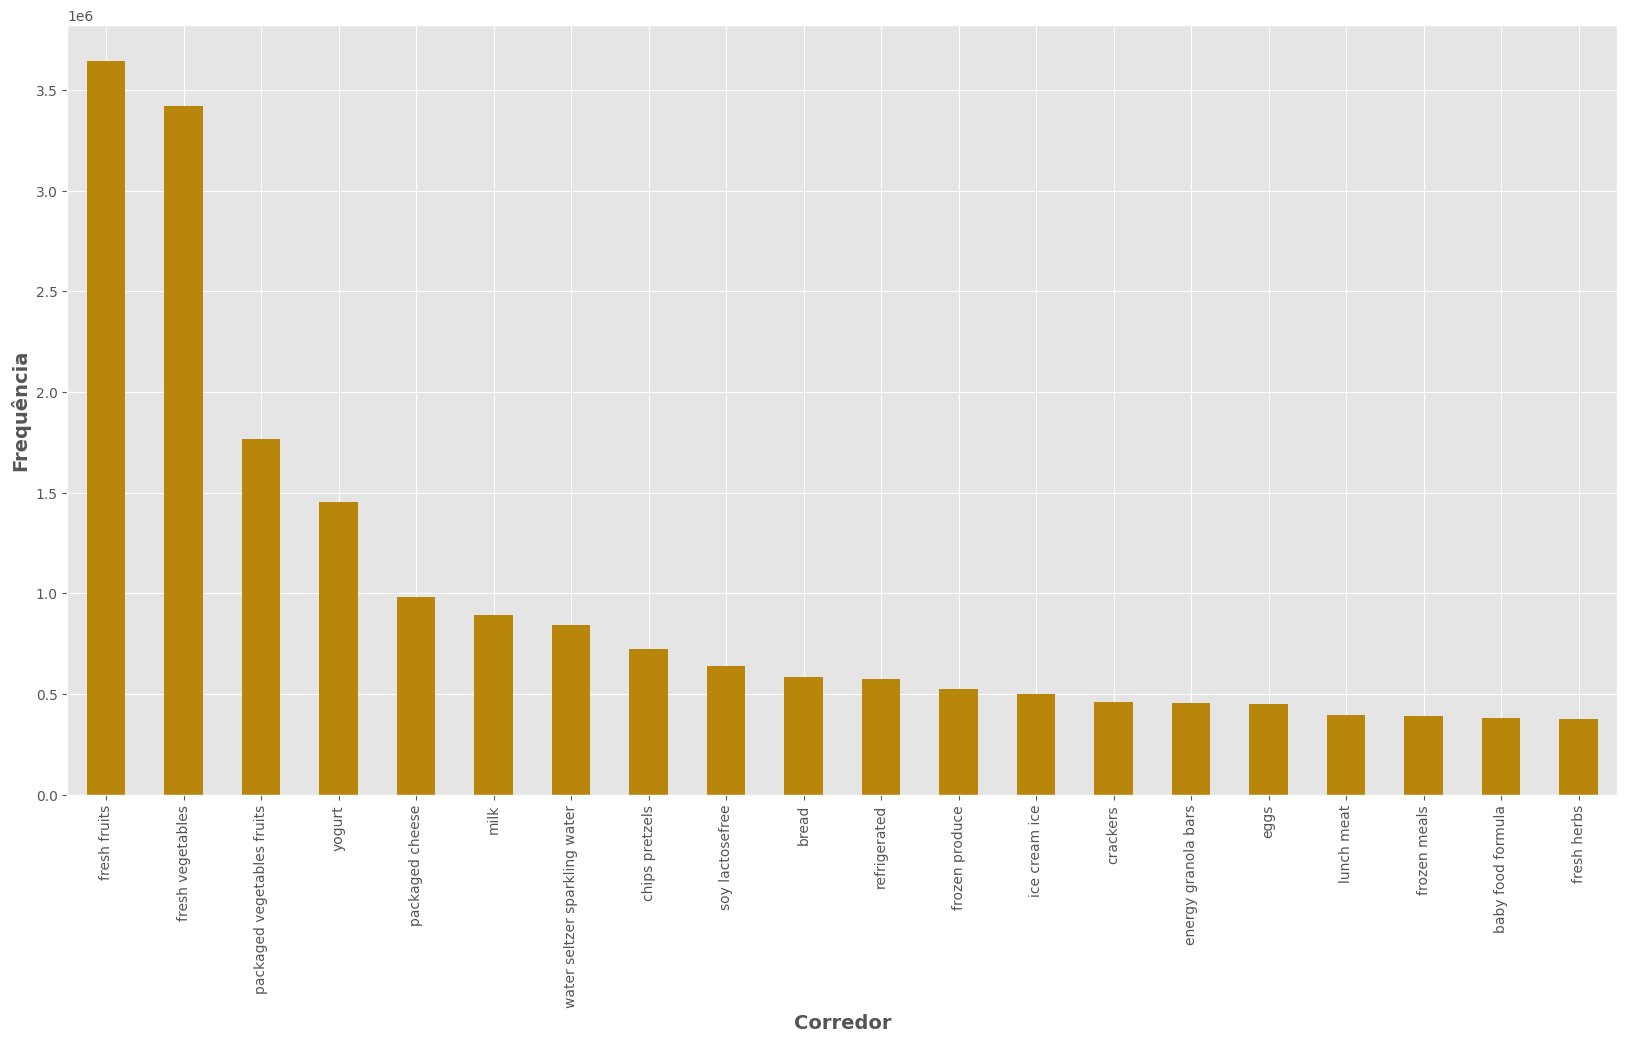

In [ ]:
# Plotar
fig, ax = plt.subplots(figsize=(20, 10))
top_20_aisles.plot(kind='bar', color='darkgoldenrod', ax=ax)
plt.xticks(rotation=90)
plt.xlabel('Corredor', fontsize=14, fontweight='bold')
plt.ylabel('Frequência', fontsize=14, fontweight='bold')

plt.show()

### 6- Quais os 20 Principais Produtos Por Frequência de Pedidos?

In [ ]:
# Obter contagem de pedidos por produto
prod_cnt = order_product_prior['product_name'].value_counts()
prod_cnt = prod_cnt.compute()

# Selecionar os 20 principais produtos
top_20_products = prod_cnt.nlargest(20)

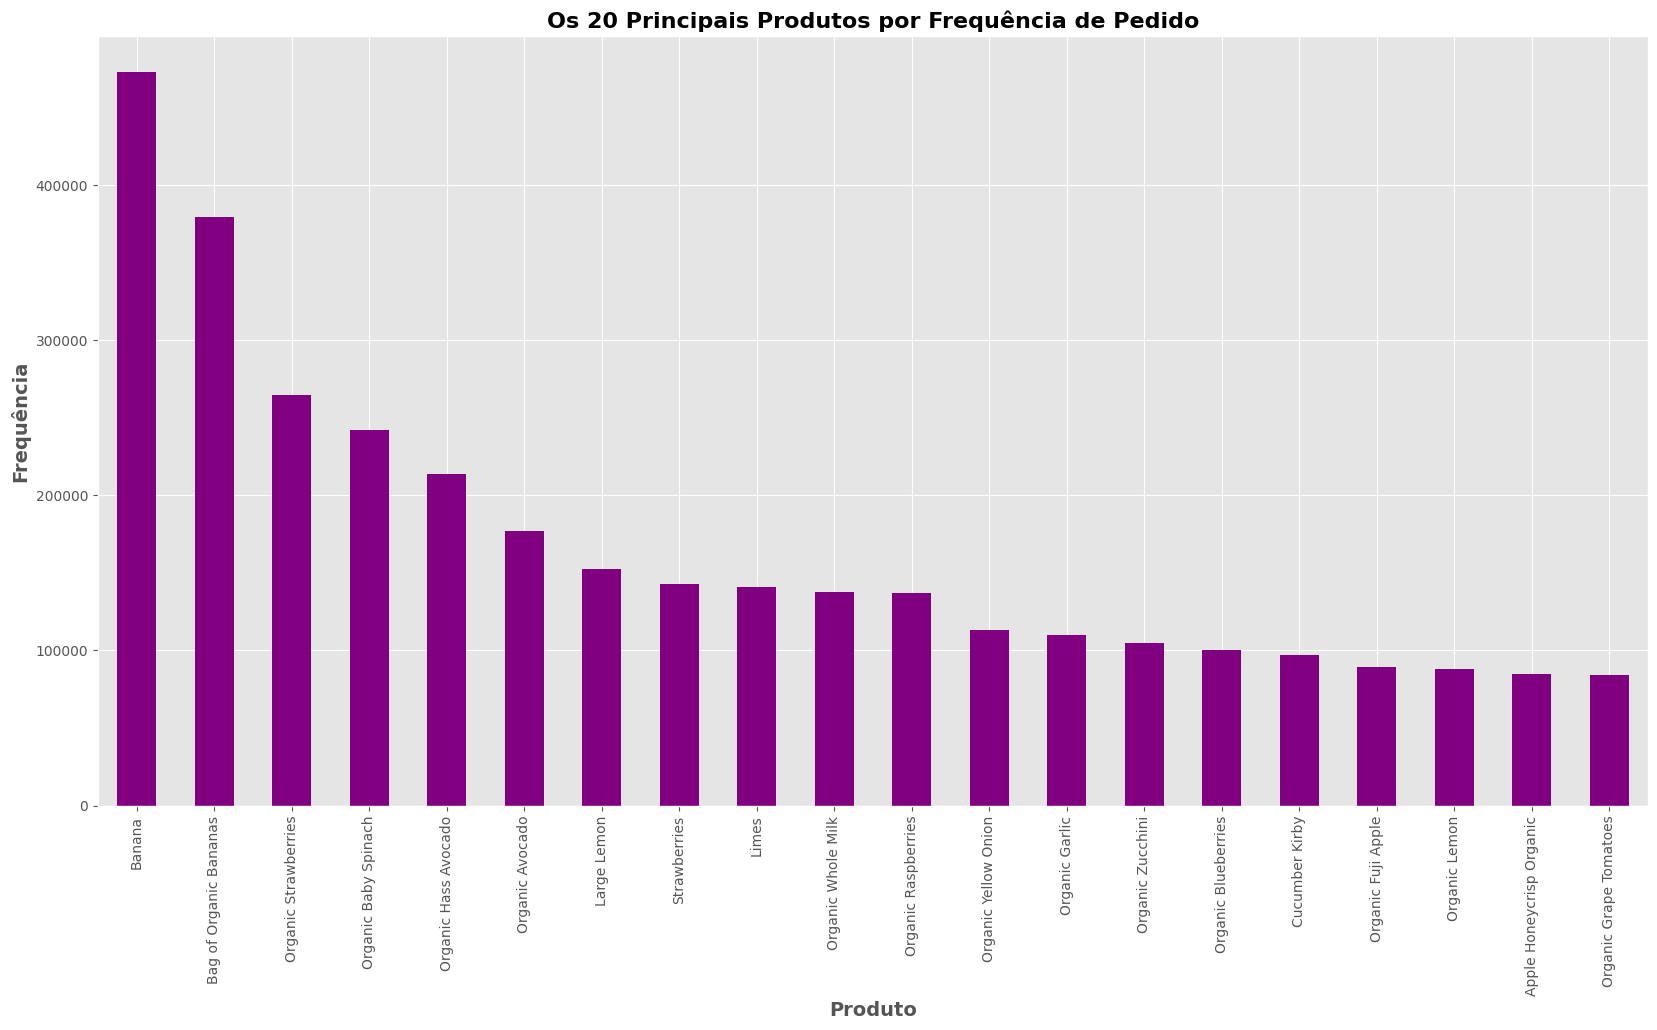

In [ ]:
# Plotar
fig, ax = plt.subplots(figsize=(20, 10))
top_20_products.plot(kind='bar', color='purple', ax=ax)

plt.xticks(rotation=90)
plt.xlabel('Produto', fontsize=14, fontweight='bold')
plt.ylabel('Frequência', fontsize=14, fontweight='bold')
plt.title('Os 20 Principais Produtos por Frequência de Pedido', fontsize=16, fontweight='bold')

plt.show()

### 7- Produtos mais frequentemente reordenados

In [ ]:
# Calculando a proporção média de reorder e a ocorrência
tmp = order_product_prior.groupby('product_id').agg(
    proportion_reordered=('reordered', 'mean'),
    n=('reordered', 'size')
)

# Filtrando os produtos com mais de 40 ocorrências
tmp = tmp[tmp['n'] > 40]

# Selecionando os 10 principais produtos com base na proporção de reordenação
tmp = tmp.nlargest(10, 'proportion_reordered')
tmp = tmp.compute()

# Mesclando
tmp = tmp.reset_index().merge(product, on='product_id', how='left')
tmp

,product_id,proportion_reordered,n,product_name,aisle_id,department_id
0,6433,0.941176,68,Raw Veggie Wrappers,13,20
1,2075,0.931034,87,Serenity Ultimate Extrema Overnight Pads,126,11
2,27740,0.920792,101,Chocolate Love Bar,45,19
3,13875,0.911111,45,Simply Sleep Nighttime Sleep Aid,6,2
4,35604,0.900000,100,Maca Buttercups,45,19
5,31418,0.900000,60,Sparking Water,115,7
6,36543,0.895522,67,Bars Peanut Butter,88,13
7,26093,0.893939,66,Soy Crisps Lightly Salted,107,19
8,38251,0.891892,111,Benchbreak Chardonnay,62,5
9,36801,0.885417,96,Organic Blueberry B Mega,31,7


### 8- Qual item as pessoas colocam no carrinho primeiro?

In [ ]:
# Ordenar por order_id e add_to_cart_order para garantir a ordem correta
ordered_products = order_product_prior.sort_values(by=['order_id', 'add_to_cart_order'])

# Obter o primeiro produto de cada pedido
first_item_per_order = ordered_products.groupby('order_id').first().reset_index()

# Agrupar pelo ID do produto e pela ordem de adição ao carrinho, calculando a contagem e a porcentagem
tmp = first_item_per_order.groupby(['product_id', 'add_to_cart_order']).size().reset_index()
tmp = tmp.rename(columns={0: 'count'})
tmp['pct'] = tmp['count'] / tmp.groupby('product_id')['count'].transform('sum')

# Filtrar os produtos adicionados como o primeiro item e com contagem maior que 10
tmp = tmp[(tmp['add_to_cart_order'] == 1) & (tmp['count'] > 10)]

# Ordenar em ordem decrescente de porcentagem
tmp = tmp.sort_values(by='pct', ascending=False)

# Mesclar com o DataFrame de produtos
tmp = tmp.merge(product, on='product_id', how='left')

# Selecionar as colunas necessárias
tmp = tmp[['product_name', 'pct', 'count']]

# Selecionar os 10 principais produtos com base na porcentagem
top_products = tmp.nlargest(10, 'pct')

# Executar o cálculo e obter o resultado como um Pandas DataFrame
result = top_products.compute()

# Exibir o resultado
print(result)

<ipython-input-54-ff17ac77f3b8>:10: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  tmp['pct'] = tmp['count'] / tmp.groupby('product_id')['count'].transform('sum')


                                        product_name  pct  count
0                         Chocolate Sandwich Cookies  1.0    272
1                                      Sashimi Combo  1.0    102
2                            Chicken Flavor Bouillon  1.0     16
3                                     Hand Sanitizer  1.0     16
4                              Chicken Apple Sausage  1.0    838
5                              Fresh Organic Carrots  1.0     29
6  Alpine Breeze Gentle Whitening for Sensitive T...  1.0     14
7                           King Size Corn Tortillas  1.0     26
8                                 Cabernet Sauvignon  1.0   1132
9                            Goji Berries, Sun-Dried  1.0    119


### 9- Análise de Novos Pedidos Semelhantes a Pedidos Anteriores (reorder)

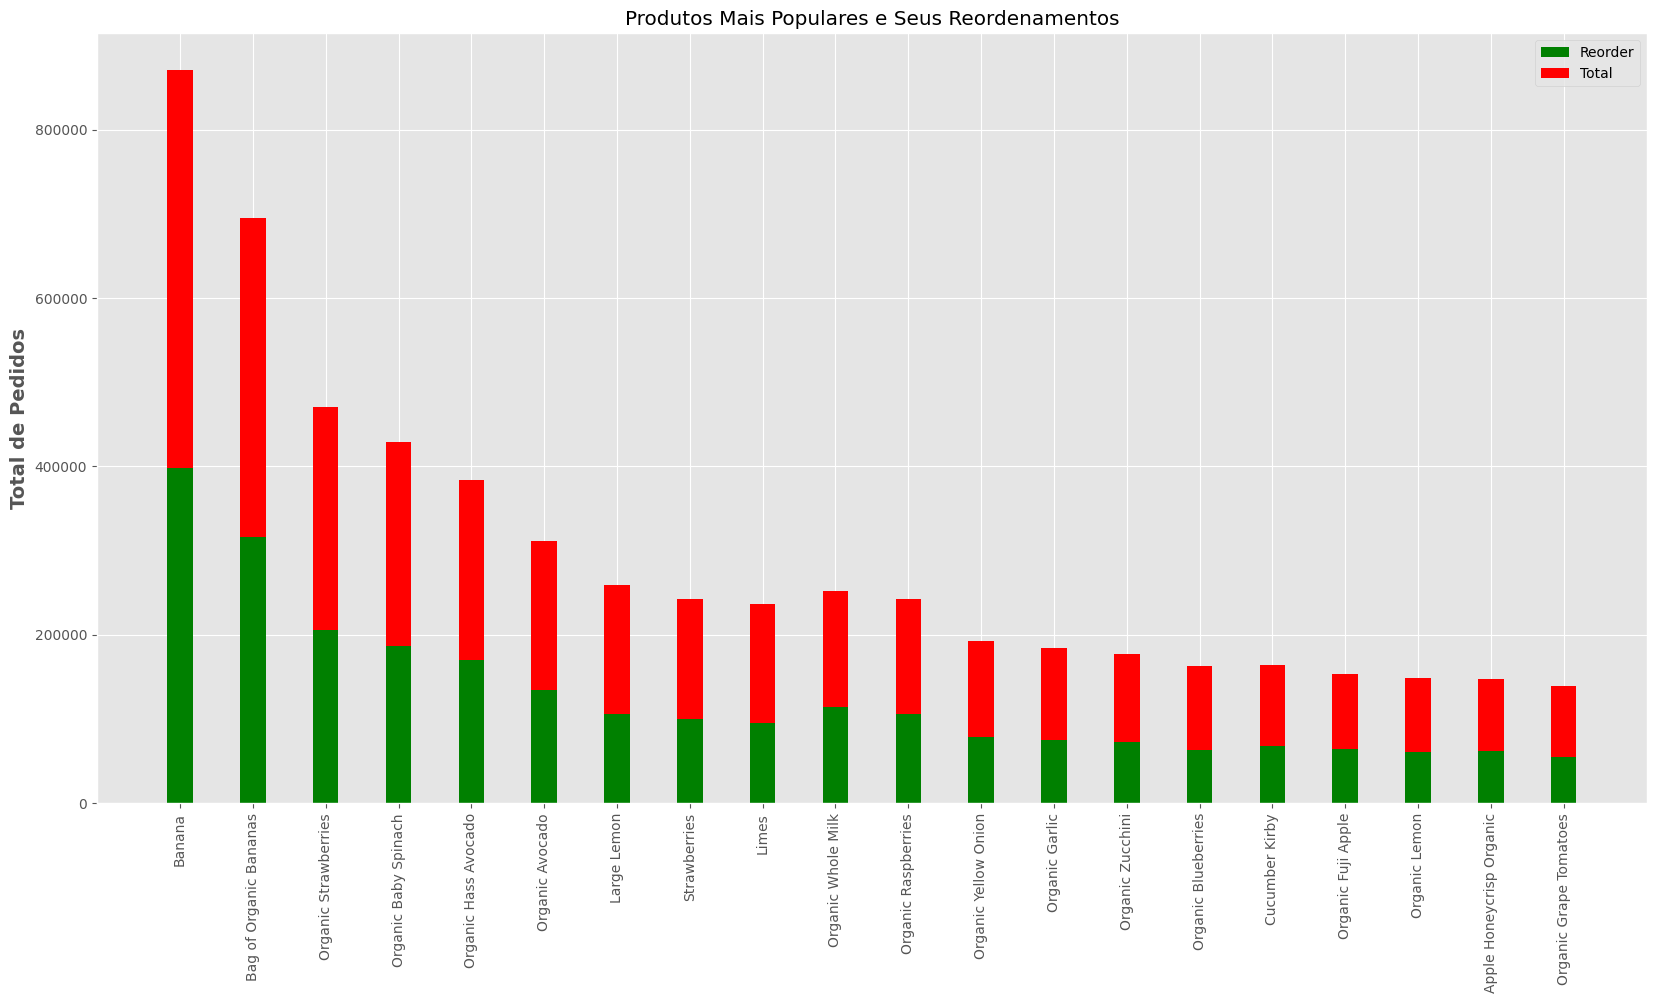

In [ ]:
# Agrupar pelo nome do produto e calcular a contagem total e a contagem de reordenamentos
temp_df = (order_product_prior.groupby('product_name')['reordered']
            .agg(['count', 'sum'])
            .rename(columns={'count': 'total', 'sum': 'reorders'}))

# Ordenar os produtos pela contagem total em ordem decrescente
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

# Selecionar os top 20 produtos
temp_df = temp_df.head(20)

# Preparar as listas para o gráfico
labels = list(temp_df['product_name'])
reorder = list(temp_df['reorders'])
total = list(temp_df['total'])

# Plotar os dados
width = 0.35
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(labels, reorder, width, label='Reorder', color='green')
ax.bar(labels, total, width, bottom=reorder, label='Total', color='red')
ax.set_ylabel('Total de Pedidos', fontsize=14, fontweight='bold')
ax.legend()
ax.set_title("Produtos Mais Populares e Seus Reordenamentos")
plt.xticks(rotation=90)
plt.show()

Temos uma proporção muito semelhante. As pessoas voltam para comprar os mesmos produtos.

### 10- Análise de Reorder Por Departamento ao Longo do Tempo

In [ ]:
# Agrupando os dados por departamento e número do pedido para calcular a taxa média de reorder
order_reorder_rates = (
    order_product_prior
    .groupby(['department', 'order_number'])['reordered']
    .mean()
    .reset_index()
)

# Renomeando a coluna 'reordered' para 'reorder_rate'
order_reorder_rates = order_reorder_rates.rename(columns={'reordered': 'reorder_rate'})

# Agrupando os dados por departamento e calculando a taxa de reorder diretamente
department_reorder_direct = (
    order_product_prior
    .groupby('department')['reordered']
    .mean()
    .reset_index()
    .rename(columns={'reordered': 'reorder_rate'})
)

department_reorder_direct.head()

,department,reorder_rate
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


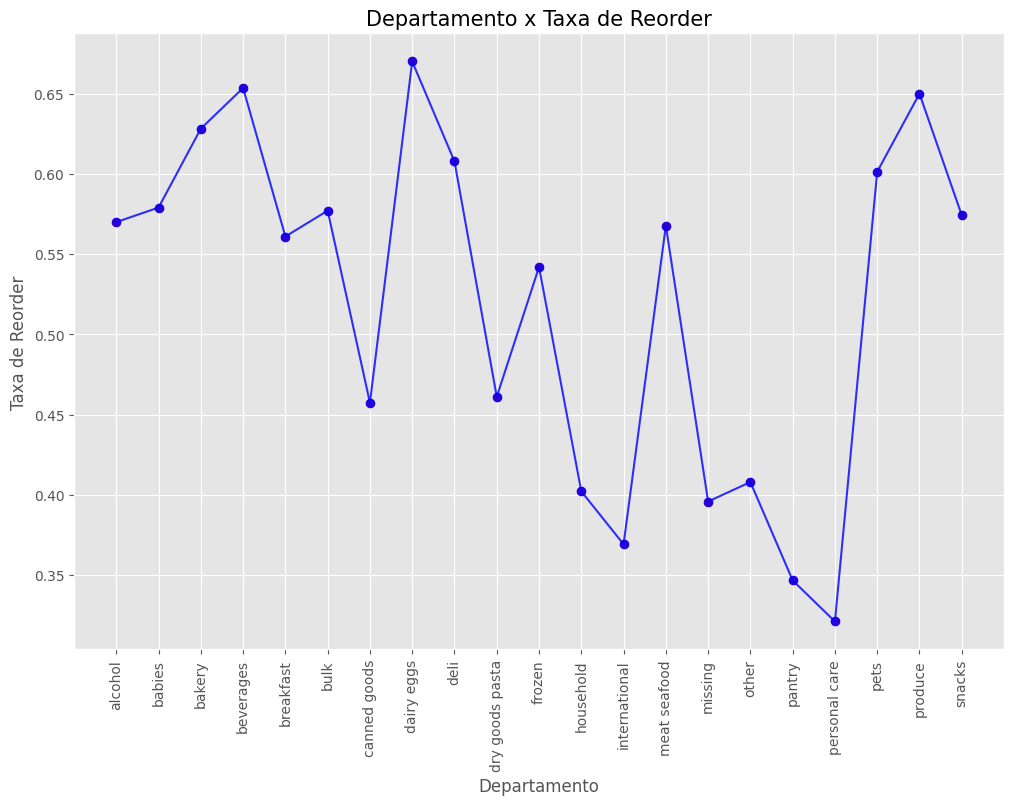

In [ ]:
# Converter o DataFrame do Dask para um DataFrame do Pandas
department_reorder_direct_pd = department_reorder_direct.compute()

# Plotar
plt.figure(figsize=(12, 8))
plt.plot(department_reorder_direct_pd['department'], department_reorder_direct_pd['reorder_rate'], marker='o', linestyle='-', color='b', alpha=0.8)
plt.scatter(department_reorder_direct_pd['department'], department_reorder_direct_pd['reorder_rate'], color='r')

plt.ylabel('Taxa de Reorder', fontsize=12)
plt.xlabel('Departamento', fontsize=12)
plt.title('Departamento x Taxa de Reorder', fontsize=15)
plt.xticks(rotation='vertical')
plt.grid(True)

# Mostrar o gráfico
plt.show()

Alguns departamentos tiveram pouquíssimos itens comprados novamente, outros, como dairy eggs, teve vários pedidos sendo refeitos. Com essas informações o tomador de decisão pode planejar melhor o estoque dos produtos

### 11- Análise de Reorder e Pedidos

In [ ]:
# Agrupar e calcular as métricas
temp_df = order_product_prior.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns={'count': 'total', 'sum': 'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()
temp_df.head()

,department,total,reorders
0,produce,9479291,6160710
1,dairy eggs,5414016,3627221
2,snacks,2887550,1657973
3,beverages,2690129,1757892
4,frozen,2236432,1211890


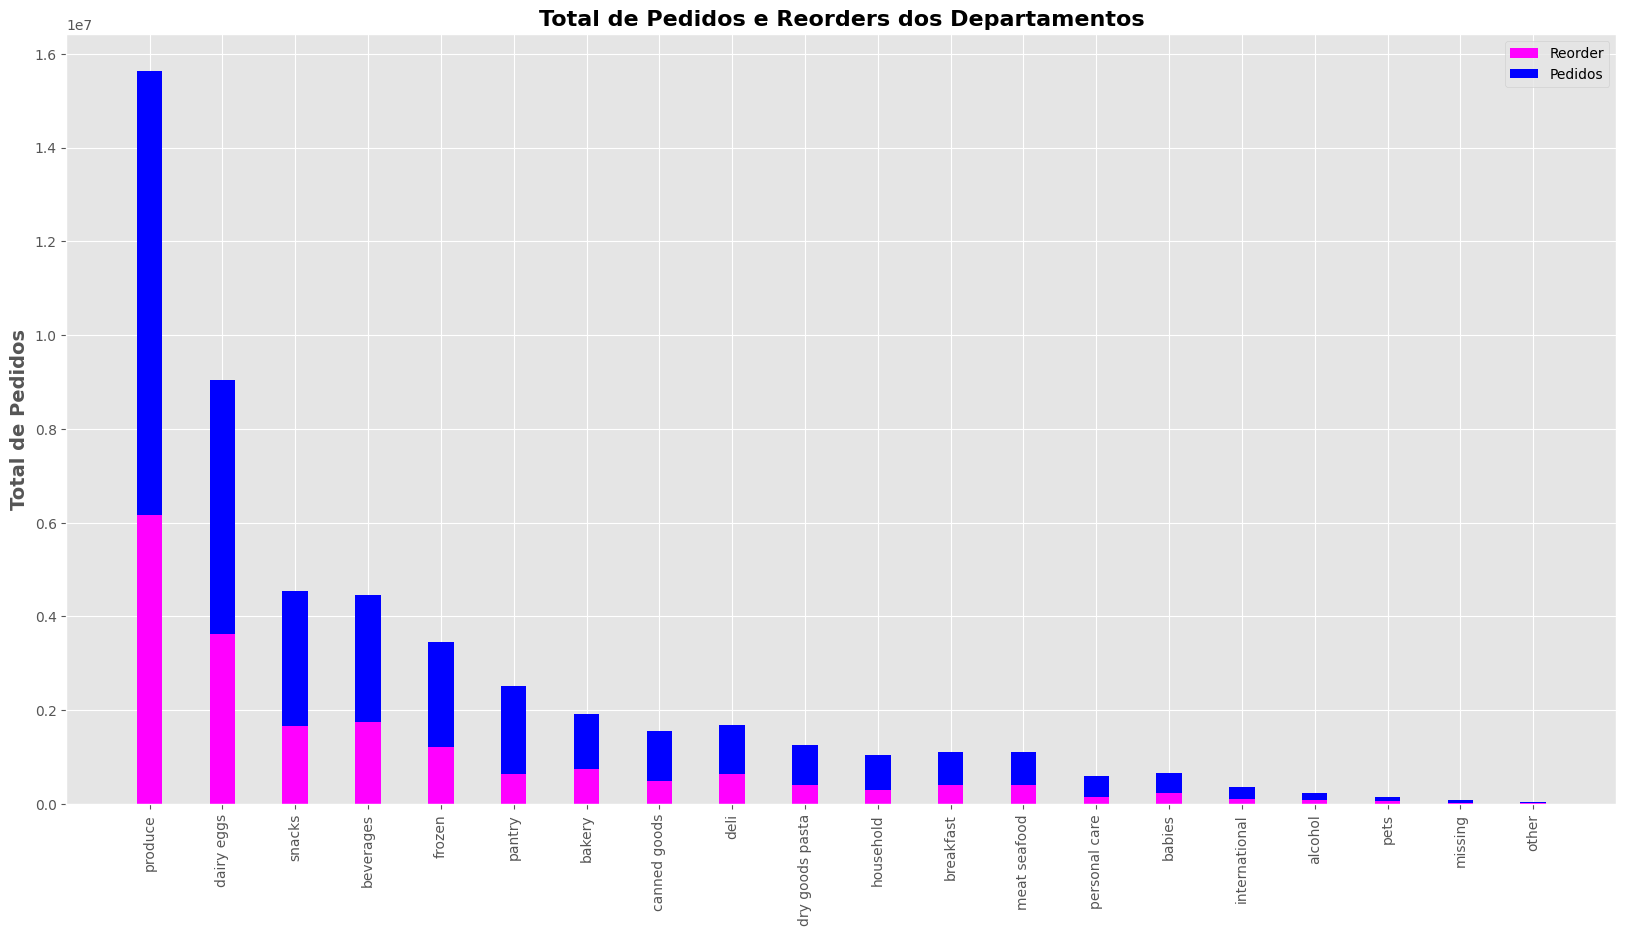

In [ ]:
# Selecionar os 20 principais departamentos
top_20_df = temp_df.head(20)

# Listas para plotagem
labels = list(top_20_df['department'])
reorder = list(top_20_df['reorders'])
total = list(top_20_df['total'])

# Plot
width = 0.35
fig, ax = plt.subplots(figsize=(20, 10))
bars1 = ax.bar(labels, reorder, width, label='Reorder', color='magenta')
bars2 = ax.bar(labels, total, width, bottom=reorder, label='Pedidos', color='blue')
ax.set_ylabel('Total de Pedidos', fontsize=14, fontweight='bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Departamentos", fontsize=16, fontweight='bold')
plt.xticks(rotation=90)

# Exibir o gráfico
plt.show()

O reorder e os pedidos são muitos simlares para cada tipo de produto, ou seja, as pessoas que compram o produto, provavelmente vão comprar de novo. Essa é uma das premissas de regra de associação.

### 12 - Análise de Reorder Por Corredor

In [ ]:
# Agrupar os dados por corredor e calcular a média da taxa de reorder
aisle_reorder_rates = (
    order_product_prior
    .groupby('aisle')['reordered']
    .mean()
    .reset_index()
    .rename(columns={'reordered': 'reorder_rate'})
)

aisle_reorder_rates.head()

,aisle,reorder_rate
0,air fresheners candles,0.309052
1,asian foods,0.351132
2,baby accessories,0.550980
3,baby bath body care,0.295770
4,baby food formula,0.590259


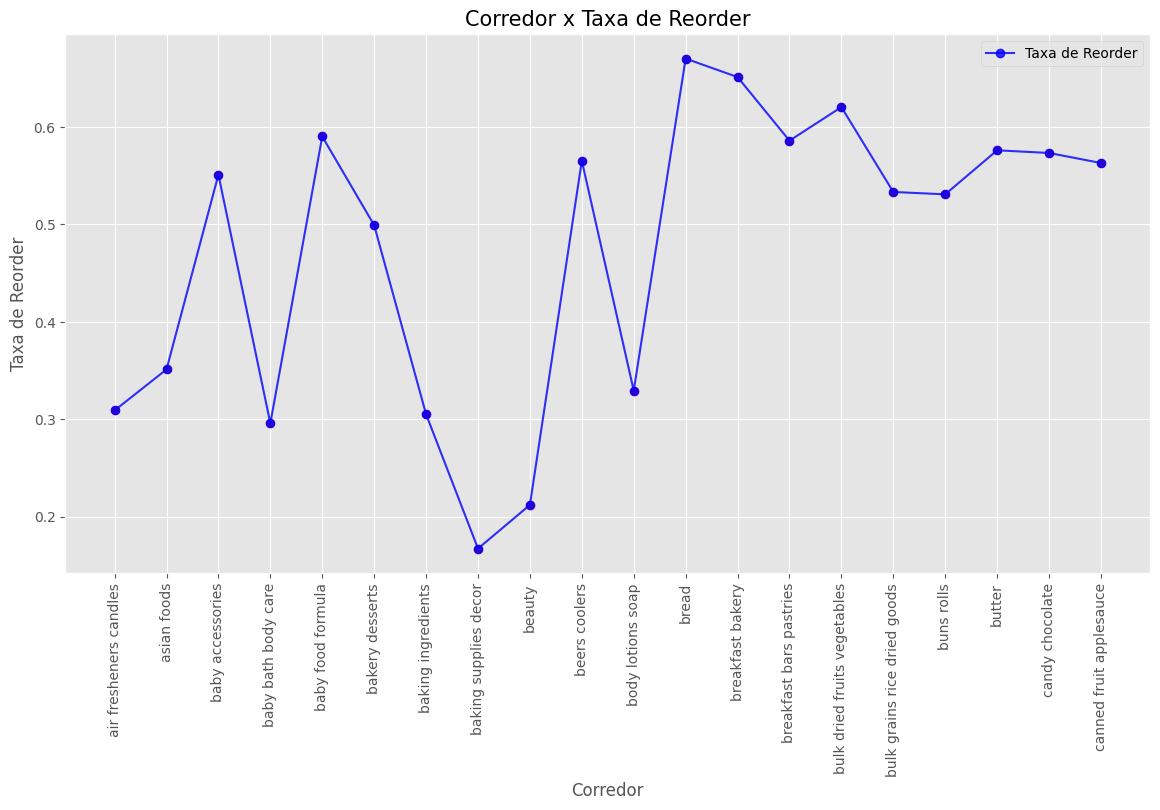

In [ ]:
# Exibimos os primeiros 20 corredores com base na ordem original (não ordenado por taxa de reorder)
top_20_aisles = aisle_reorder_rates.head(20)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(top_20_aisles['aisle'], top_20_aisles['reorder_rate'], marker='o', linestyle='-', color='b', alpha=0.8, label='Taxa de Reorder')
plt.scatter(top_20_aisles['aisle'], top_20_aisles['reorder_rate'], color='r')
plt.ylabel('Taxa de Reorder', fontsize=12)
plt.xlabel('Corredor', fontsize=12)
plt.title("Corredor x Taxa de Reorder", fontsize=15)
plt.xticks(rotation='vertical')
plt.legend()


plt.show()

Baking é o corredor que recebeu menor quantidade de novos pedidos. Já em bread, temos uma quantidade grande de novos pedidos

### 13- Análise de Reorder Por Corredor (Total)

In [ ]:
# Agrupar por 'aisle' e calcular 'count' e 'sum' de 'reordered'
temp_df = order_product_prior.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns={'count': 'total', 'sum': 'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()
temp_df.head()

,aisle,total,reorders
0,fresh fruits,3642188,2615469
1,fresh vegetables,3418021,2032172
2,packaged vegetables fruits,1765313,1127177
3,yogurt,1452343,997018
4,packaged cheese,979763,573383


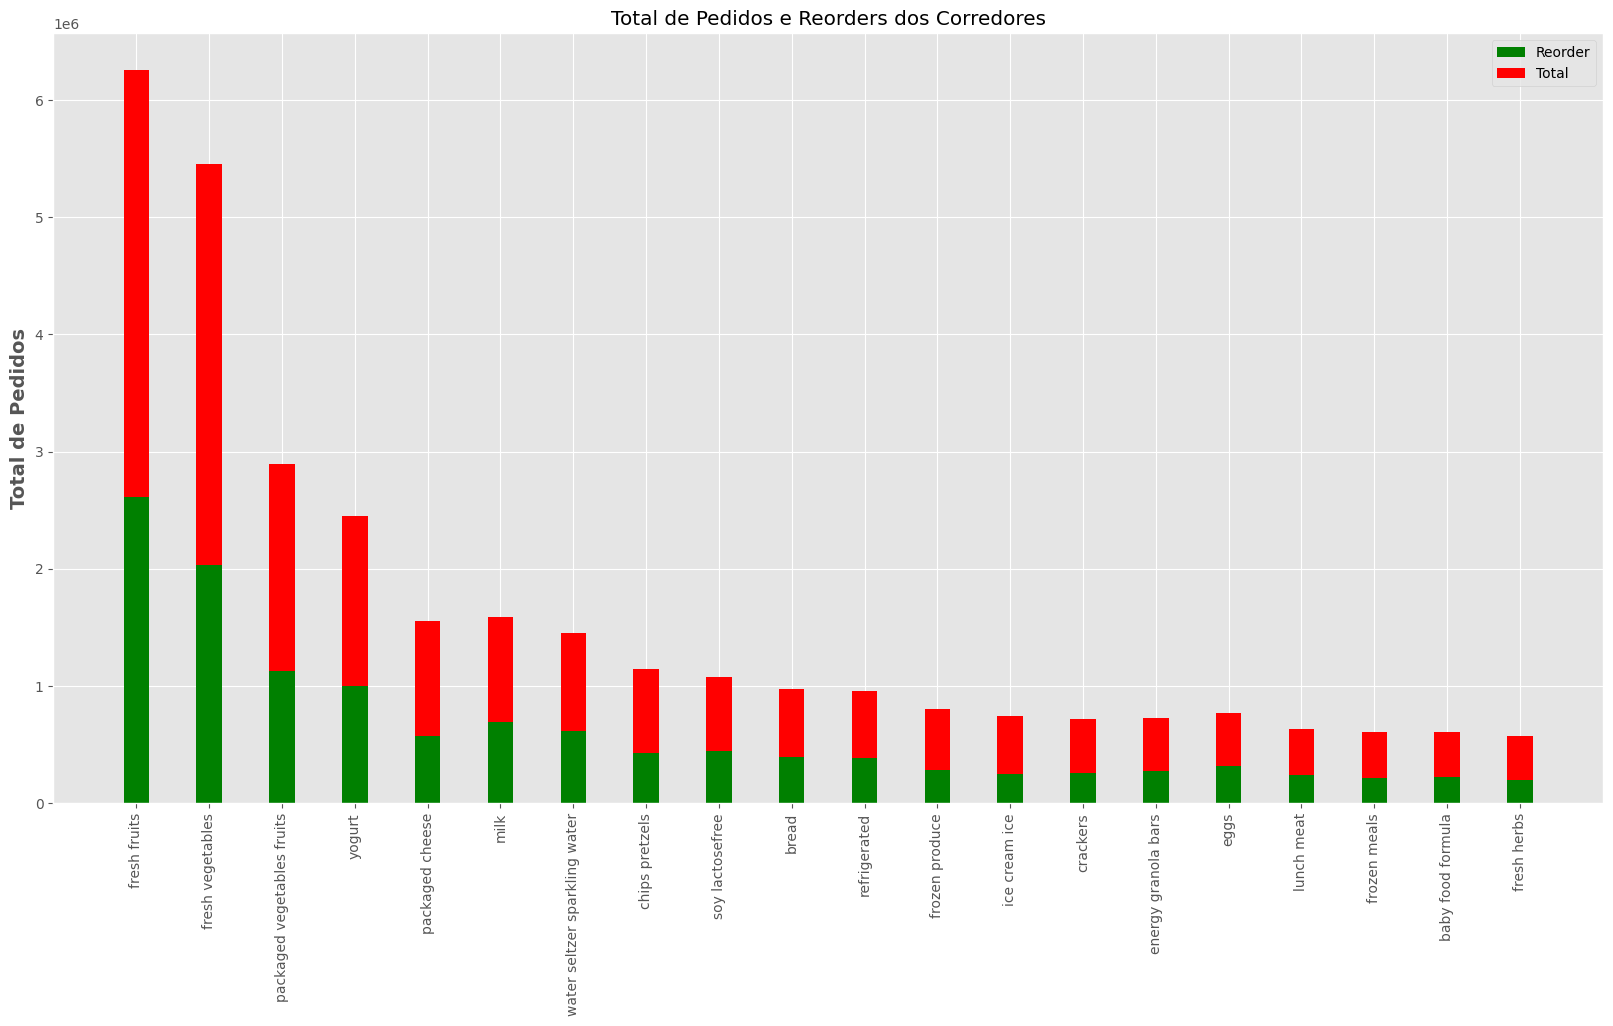

In [ ]:
# Selecionar os 20 principais corredores
top_20_df = temp_df.head(20)

# Listas para plotagem
labels = list(top_20_df['aisle'])
reorder = list(top_20_df['reorders'])
total = list(top_20_df['total'])

# Plot
width = 0.35
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(labels, reorder, width, label='Reorder', color='green')
ax.bar(labels, total, width, bottom=reorder, label='Total', color='red')
ax.set_ylabel('Total de Pedidos', fontsize=14, fontweight='bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Corredores")
plt.xticks(rotation=90)
plt.show()

Claramente existe um padrão de compra dos usuários.
Agora precisamos implementar o algoritmo que vai minerar esse padrão e entregar
as regras de associação.

Vamos verificar a relação entre como a ordem de adição do produto ao carrinho afeta a proporção de novos pedidos

In [ ]:
# Limitar a ordem de adição a um valor máximo de 70 diretamente no Dask
order_product_prior = order_product_prior.assign(
    add_to_cart_order_mod=order_product_prior['add_to_cart_order'].clip(upper=70)
)

# Agrupar pelos valores da nova coluna e calcular a média da taxa de reorder
grouped_df = order_product_prior.groupby('add_to_cart_order_mod')['reordered'].mean().reset_index()
grouped_df.compute().head()

,add_to_cart_order_mod,reordered
0,1,0.677533
1,2,0.676251
2,3,0.658037
3,4,0.636958
4,5,0.617383


Podemos observar que quando o produto foi adicionado como primeira posição do carrinho. Isso  gerou um novo pedido 68% das vezes.  

Quando a pessoa teve dois produtos no carrinho 67% das vezes, ela fez um novo pedido.

Observamos que a medida que aumenta o número de produtos, diminui a média de novos pedidos (o que é normal).

## Implementação do Algoritmo Apriori

In [ ]:
# Prepara a tupla com as transações
transactions_tup = [tuple(row) for row in transactions['Products'].tolist()]

### Executa o Algoritmo Apriori Com Support = 0.01 e Confidence = 0.2

In [ ]:
st = datetime.now()
itemsets_ap, rules_ap = apriori(transactions_tup[:500000], min_support = 0.01, min_confidence = 0.2)
print('Tempo de Execução : ', datetime.now() - st)

Tempo de Execução :  0:00:13.449996


In [ ]:
rules_ap

[{21137} -> {13176},
 {21903} -> {13176},
 {27966} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {21903} -> {24852},
 {28204} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852}]

Essas são as regras de associação.(Quem comprou um produto, também comprou o outro produto)

In [ ]:
# Listas de itens para considerar
item_A = [27966,47209,21137,47766,21903,49683,47626,28204,16797,21903,21137,27966]
item_B = [13176,13176,24852,24852,24852,24852,24852,24852,24852,13176,13176,21137]
temp = pd.DataFrame()
temp['itemA'] = item_A
temp['itemB'] = item_B

In [ ]:
# Listas para as métricas
support_A = []
support_B = []
support_AB = []
confidence_AB = []
lift_AB = []

In [ ]:
# Loop
for i in range(len(temp)):

    # Calcula o support de A
    support_A.append(itemsets_ap[1][tuple([temp['itemA'][i],])] / 500000)

    # Calcula o support de B
    support_B.append(itemsets_ap[1][tuple([temp['itemB'][i],])] / 500000)

    # Calcula o support de A e B
    if tuple([temp['itemA'][i],temp['itemB'][i]]) in itemsets_ap[2].keys():
        support_AB.append(itemsets_ap[2][tuple([temp['itemA'][i],temp['itemB'][i]])] / 500000)
    else:
        support_AB.append(itemsets_ap[2][tuple([temp['itemB'][i],temp['itemA'][i]])] / 500000)

    # Calcula a confidence
    confidence_AB.append(support_AB[i] / support_A[i])

    # Calcula o lift
    lift_AB.append(support_AB[i] / (support_A[i] * support_B[i]))

In [ ]:
# Dataframe com as regras de associação (juntando tudo em um único dataframe)
df_rules_ap = pd.DataFrame()
df_rules_ap['product_id'] = item_A
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_A'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['product_id'] = item_B
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_B'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['Support_A'] = support_A
df_rules_ap['Support_B'] = support_B
df_rules_ap['Support_AB'] = support_AB
df_rules_ap['Confidence_AB'] = confidence_AB
df_rules_ap['Lift_AB'] = lift_AB

In [ ]:
# Ordenando pelo Confidence
df_rules_ap.sort_values(by = 'Confidence_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
7,Organic Fuji Apple,Banana,0.027902,0.146912,0.010592,0.379614,2.583958
5,Cucumber Kirby,Banana,0.030768,0.146912,0.010088,0.327873,2.231765
3,Organic Avocado,Banana,0.054262,0.146912,0.016322,0.300800,2.047483
0,Organic Raspberries,Bag of Organic Bananas,0.042548,0.117830,0.012544,0.294820,2.502079
1,Organic Hass Avocado,Bag of Organic Bananas,0.066770,0.117830,0.019520,0.292347,2.481090
8,Strawberries,Banana,0.044352,0.146912,0.012840,0.289502,1.970582
6,Large Lemon,Banana,0.047404,0.146912,0.012542,0.264577,1.800920
11,Organic Raspberries,Organic Strawberries,0.042548,0.082168,0.010398,0.244383,2.974185
10,Organic Strawberries,Bag of Organic Bananas,0.082168,0.117830,0.019250,0.234276,1.988255
4,Organic Baby Spinach,Banana,0.074406,0.146912,0.015826,0.212698,1.447791


Quem compra maça fuji organica também compra Banana e assim por diante. Também temos a força dessas relações.

In [ ]:
# Ordenando pelo Lift
df_rules_ap.sort_values(by = 'Lift_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
11,Organic Raspberries,Organic Strawberries,0.042548,0.082168,0.010398,0.244383,2.974185
7,Organic Fuji Apple,Banana,0.027902,0.146912,0.010592,0.379614,2.583958
0,Organic Raspberries,Bag of Organic Bananas,0.042548,0.117830,0.012544,0.294820,2.502079
1,Organic Hass Avocado,Bag of Organic Bananas,0.066770,0.117830,0.019520,0.292347,2.481090
5,Cucumber Kirby,Banana,0.030768,0.146912,0.010088,0.327873,2.231765
3,Organic Avocado,Banana,0.054262,0.146912,0.016322,0.300800,2.047483
10,Organic Strawberries,Bag of Organic Bananas,0.082168,0.117830,0.019250,0.234276,1.988255
8,Strawberries,Banana,0.044352,0.146912,0.012840,0.289502,1.970582
6,Large Lemon,Banana,0.047404,0.146912,0.012542,0.264577,1.800920
9,Organic Baby Spinach,Bag of Organic Bananas,0.074406,0.117830,0.015454,0.207698,1.762695


### Executa o Algoritmo Apriori Com Support = 0.005 e Confidence = 0.2

In [ ]:
st = datetime.now()
itemsets_ap_1, rules_ap_1 = apriori(transactions_tup[:500000], min_support = 0.005, min_confidence = 0.2)
print('Tempo de Execução: ', datetime.now() - st)

Tempo de Execução:  0:00:14.811136


In [ ]:
rules_ap_1

[{4605} -> {24852},
 {4920} -> {24852},
 {5876} -> {13176},
 {5876} -> {47209},
 {8277} -> {13176},
 {8277} -> {24852},
 {9076} -> {24852},
 {19057} -> {13176},
 {21137} -> {13176},
 {21903} -> {13176},
 {22935} -> {13176},
 {27966} -> {13176},
 {30391} -> {13176},
 {37646} -> {13176},
 {39275} -> {13176},
 {45007} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {30391} -> {21137},
 {39275} -> {21137},
 {21903} -> {24852},
 {26209} -> {24852},
 {27845} -> {24852},
 {28204} -> {24852},
 {30489} -> {24852},
 {37646} -> {24852},
 {40706} -> {24852},
 {42265} -> {24852},
 {45066} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852},
 {31717} -> {26209},
 {30391} -> {47209}]

In [ ]:
# Lista de itens para considerar
item_A1 = [27966,47209,4605,21137,47766,21903,49683,5876,37646,40706,47626,5876,30391,22935,37646,31717,
           28204,27845,24964,45066,9076,16797,21903,8277,30391,21137,27966,19057,26209,45007,39275,30489,
           42265,30391,8277,4920,39275,44632]
item_B1 = [13176,13176,24852,24852,24852,24852,24852,47209,24852,24852,24852,13176,13176,13176,13176,26209,
           24852,24852,22935,24852,24852,24852,13176,24852,47209,13176,21137,13176,24852,13176,21137,24852,
           24852,21137,13176,24852,13176,24852]
temp1 = pd.DataFrame()
temp1['itemA'] = item_A1
temp1['itemB'] = item_B1

In [ ]:
# Listas de métricas
support_A1 = []
support_B1 = []
support_AB1 = []
confidence_AB1 = []
lift_AB1 = []

In [ ]:
# Loop
for i in range(len(temp1)):

    item_a = temp1['itemA'][i]
    item_b = temp1['itemB'][i]
    key_ab = tuple(sorted([item_a, item_b]))  # Ordena a tupla para garantir consistência

    # Calcula o support de A
    support_A1.append(itemsets_ap_1[1].get(tuple([item_a, ]), 0) / 500000)

    # Calcula o support de B
    support_B1.append(itemsets_ap_1[1].get(tuple([item_b, ]), 0) / 500000)

    # Calcula o support de A e B
    support_AB = itemsets_ap_1[2].get(key_ab, 0) / 500000
    support_AB1.append(support_AB)

    # Calcula a confidence
    if support_A1[-1] > 0:
        confidence_AB1.append(support_AB / support_A1[-1])
    else:
        confidence_AB1.append(0)

    # Calcula o lift
    if support_A1[-1] > 0 and support_B1[-1] > 0:
        lift_AB1.append(support_AB / (support_A1[-1] * support_B1[-1]))
    else:
        lift_AB1.append(0)

In [ ]:
# Dataframe com as regras de associação
df_rules_ap1 = pd.DataFrame()
df_rules_ap1['product_id'] = item_A1
df_rules_ap1 = df_rules_ap1.merge(product, on = 'product_id', how = 'left')
df_rules_ap1['Product_A'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['product_id'] = item_B1
df_rules_ap1 = df_rules_ap1.merge(product, on = 'product_id', how = 'left')
df_rules_ap1['Product_B'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['Support_A'] = support_A1
df_rules_ap1['Support_B'] = support_B1
df_rules_ap1['Support_AB'] = support_AB1
df_rules_ap1['Confidence_AB'] = confidence_AB1
df_rules_ap1['Lift_AB'] = lift_AB1

In [ ]:
df_rules_ap1.sort_values(by = 'Confidence_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
16,Organic Fuji Apple,Banana,0.027902,0.146912,0.010592,0.379614,2.583958
19,Honeycrisp Apple,Banana,0.025016,0.146912,0.008822,0.352654,2.400446
6,Cucumber Kirby,Banana,0.030768,0.146912,0.010088,0.327873,2.231765
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023084,0.117830,0.007020,0.304107,2.580894
35,Seedless Red Grapes,Banana,0.025742,0.146912,0.007756,0.301297,2.050871
4,Organic Avocado,Banana,0.054262,0.146912,0.016322,0.300800,2.047483
0,Organic Raspberries,Bag of Organic Bananas,0.042548,0.117830,0.012544,0.294820,2.502079
20,Blueberries,Banana,0.017358,0.146912,0.005080,0.292660,1.992080
1,Organic Hass Avocado,Bag of Organic Bananas,0.066770,0.117830,0.019520,0.292347,2.481090
21,Strawberries,Banana,0.044352,0.146912,0.012840,0.289502,1.970582


Mesmo mudando os valores das métricas, essa relação continua forte.

In [ ]:
df_rules_ap1.sort_values(by = 'Lift_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
15,Organic Cilantro,Limes,0.021820,0.043824,0.005602,0.256737,5.858364
18,Organic Garlic,Organic Yellow Onion,0.033994,0.035396,0.006796,0.199918,5.648029
7,Organic Lemon,Organic Hass Avocado,0.027374,0.066770,0.006758,0.246877,3.697418
24,Organic Cucumber,Organic Hass Avocado,0.024908,0.066770,0.005394,0.216557,3.243327
26,Organic Raspberries,Organic Strawberries,0.042548,0.082168,0.010398,0.244383,2.974185
30,Organic Blueberries,Organic Strawberries,0.031288,0.082168,0.007504,0.239836,2.918854
16,Organic Fuji Apple,Banana,0.027902,0.146912,0.010592,0.379614,2.583958
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023084,0.117830,0.007020,0.304107,2.580894
33,Organic Cucumber,Organic Strawberries,0.024908,0.082168,0.005188,0.208286,2.534886
0,Organic Raspberries,Bag of Organic Bananas,0.042548,0.117830,0.012544,0.294820,2.502079
